In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
filepath = '/content/drive/MyDrive/Progetto Colab/'

# Importazione dataset e controllo valori nulli

In [84]:
import pandas as pd
df = pd.read_excel(filepath+'data/Finance.xlsx')
df

,Tipo,Score,Text
0,Finance,Positive,'bout to pas in pps.. im in both '
1,Finance,Positive,'short toasting very well'
2,Finance,Negative,'is dead money for the rest of the year a ipho...
3,Finance,Positive,'already climbing pm.'
4,Finance,Positive,'how are yall bearish smfh'
...,...,...,...
11823,Finance,Positive,'this seems familiar ;)'
11824,Finance,Positive,'wow!'
11825,Finance,Negative,'not all stock go up. big pharma company stock...
11826,Finance,Positive,'bought puts.... for a credit spread '


In [85]:
df.isna().sum()

Tipo     0
Score    0
Text     0
dtype: int64

In [86]:
df.Score.value_counts()

Positive    8485
Negative    3343
Name: Score, dtype: int64

### Rimozione NaN e split X e y

In [87]:
df_not_na = df[~(df['Text'].isna())]
raw_text = df_not_na['Text']
#assegno i valori alla mia y
y = df_not_na['Score'].tolist()
raw_text[5]

'23 April 2010 - Finnish construction and engineering company Outotec Oyj HEL : OTE1V said today it slipped to a net loss of EUR7 .3 m in the first quarter of 2010 from a net profit of EUR12 .5 m in the corresponding period last year .'

### Lowercase, Remove punctuation, Tokenize, Lemmatization

In [88]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [89]:
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

text = raw_text.str.lower().str.replace('[^\w\s\d]',' ', regex=True) # \d tiene anche i caratteri numerici
text = text.str.split()
text = text.apply(lambda x: [lemmatizer.lemmatize(sent) for sent in x])
for row in text:
    [row.remove(i) for i in row if len(i) < 2]
print(text[0])
train_sentences = []
for row in text:
    train_sentences.append(' '.join([item for item in row ]))
train_sentences[1]

['bout', 'to', 'pa', 'in', 'pps', 'im', 'in', 'both']


'short toasting very well'

### BoW

In [90]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#n_gram da 1 a 1, quindi mono gram, imposto 2000 features, quindi si ferma alle 2000 parole piu frequenti
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=2000)
X = vectorizer.fit_transform(train_sentences)

#salva in un dizionario i nomi delle features, associando a un codice
feature_names = vectorizer.get_feature_names()
X = X.toarray()
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Modello di classificazione

### Creazione train/test

In [91]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### Grid Search Naive bayes

In [92]:
#Questa griglia ci permette di determinare i migliori parametri di tuning
#Il Naive bayes non è scelto per il progetto
# Best Accuracy : 0.853, 'alpha': 1.0 Cibo
# Best Accuracy : 0.754, 'alpha': 0.5 Finance
# Best Accuracy : 0.861, 'alpha': 10.0 Disneyland
# Best Accuracy : 0.855, 'alpha': 10.0 Electronic

'''
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
params = {'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 10.0, ],}

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(x_train,y_train)

print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)
'''

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.naive_bayes import MultinomialNB\nparams = {'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 10.0, ],}\n\nmultinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)\nmultinomial_nb_grid.fit(x_train,y_train)\n\nprint('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)\nprint('Best Parameters : ',multinomial_nb_grid.best_params_)\n"

### Grid Search Random Forest

In [93]:
#Utilizzare solo in caso di necessità (tempi molto lunghi)
#Questa griglia ci permette di determinare i migliori parametri di tuning
#Best: 0.821146 using {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300} Cibo
#Best: 0.787776 using {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200} Finance
#Best: 0.821431 using {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300} Disneyland
#Best: 0.869970 using {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300} Electronic
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#cross_validated_grid_search for Random Forest

model = RandomForestClassifier()
param_grid = {'n_estimators': [200, 300],#numero di alberi
               'criterion': ['gini', 'entropy'],#purezza misurata con gini e entropia
               'max_depth': [None, 5, 10], #profondità massima dell'albero
               'min_samples_split': [2, 10, 20]} #Il numero minimo di campioni necessari per dividere un nodo interno

grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3, verbose=2, n_jobs=-1)#default è accuracy
# Fit the random search model
%time grid_result = grid.fit(x_train, y_train)

#print grid search results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn import svm\n\n#cross_validated_grid_search for Random Forest\n\nmodel = RandomForestClassifier()\nparam_grid = {\'n_estimators\': [200, 300],#numero di alberi\n               \'criterion\': [\'gini\', \'entropy\'],#purezza misurata con gini e entropia\n               \'max_depth\': [None, 5, 10], #profondità massima dell\'albero\n               \'min_samples_split\': [2, 10, 20]} #Il numero minimo di campioni necessari per dividere un nodo interno\n\ngrid = GridSearchCV(estimator = model, param_grid = param_grid, cv=3, verbose=2, n_jobs=-1)#default è accuracy\n# Fit the random search model\n%time grid_result = grid.fit(x_train, y_train)\n\n#print grid search results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_res

### Modello migliore per modello surrogato

In [94]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Modello RF
#model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_split= 2, n_estimators= 300) #cibo e Disneyland
#model = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_split= 10, n_estimators= 300) #Electronic
model = RandomForestClassifier(criterion= 'entropy', max_depth= None, min_samples_split= 10, n_estimators= 200) #Finance

model.fit(X,y)
predicted = model.predict(X)

In [95]:
import pandas as pd
import numpy as np

RF = pd.DataFrame(list(zip(X,predicted)), columns = ['testo','score'])

### Modello surrogato per assegnazione pesi

In [96]:
X = RF['testo'].tolist()
y = RF['score'].tolist()

X = np.array(X)
y = np.array(y)

In [97]:
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight=None)

model.fit(X, y)

pred = model.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Comprensione pesi e assegnazione punteggio

(array([  3.,   7.,  18.,  61., 250., 670., 700., 248.,  35.,   8.]),
 array([-3.55765728, -2.96328198, -2.36890668, -1.77453138, -1.18015608,
        -0.58578077,  0.00859453,  0.60296983,  1.19734513,  1.79172043,
         2.38609573]),
 <a list of 10 Patch objects>)

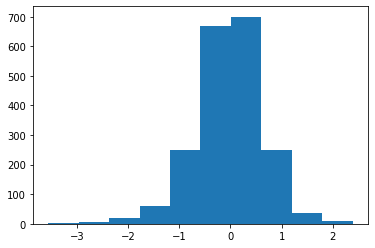

In [98]:
coef=model.coef_#valori coefficiente
#feature_names sono le parole associate ai coefficiente

#Distribuzione coefficiente
import matplotlib
import matplotlib.pyplot as pp
pp.hist(coef[0])

### Tecnica 1

In [99]:
'''
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>2: #coefficiente maggiore di 2, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]>1.5: #coefficiente maggiore di 1.5, punteggio 3.5
    df1.Punteggio[i]=3.5
  elif df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 3
    df1.Punteggio[i]=3
  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 2.5
    df1.Punteggio[i]=2.5
  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -2.5
    df1.Punteggio[i]=-2.5
  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -3
    df1.Punteggio[i]=-3
  elif df1.Coeff[i]<-1.5: #coefficiente minore di -1.5, punteggio -3.5
    df1.Punteggio[i]=-3.5
  elif df1.Coeff[i]<-2: #coefficiente minore di -2, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 
'''

'\ndf1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})\ndf1.sort_values(by=["Coeff"], ascending = False, inplace = True)\nfor i in range(len(df1)):\n  if df1.Coeff[i]>2: #coefficiente maggiore di 2, punteggio 4\n    df1.Punteggio[i]=4\n  elif df1.Coeff[i]>1.5: #coefficiente maggiore di 1.5, punteggio 3.5\n    df1.Punteggio[i]=3.5\n  elif df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 3\n    df1.Punteggio[i]=3\n  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 2.5\n    df1.Punteggio[i]=2.5\n  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -2.5\n    df1.Punteggio[i]=-2.5\n  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -3\n    df1.Punteggio[i]=-3\n  elif df1.Coeff[i]<-1.5: #coefficiente minore di -1.5, punteggio -3.5\n    df1.Punteggio[i]=-3.5\n  elif df1.Coeff[i]<-2: #coefficiente minore di -2, punteggio -4\n    df1.Punteggio[i]=-4\n  else:\n    df1.drop(i, inplace=True) \n'

### Tecnica 2 (vincente)

In [100]:
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>0.6: #coefficiente maggiore di 0.6, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]<-0.6: #coefficiente minore di -0.6, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Tecnica 3

In [101]:
'''
df1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})
df1.sort_values(by=["Coeff"], ascending = False, inplace = True)
for i in range(len(df1)):
  if df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 4
    df1.Punteggio[i]=4
  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 3
    df1.Punteggio[i]=3
  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -3
    df1.Punteggio[i]=-3
  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -4
    df1.Punteggio[i]=-4
  else:
    df1.drop(i, inplace=True) 
'''

'\ndf1 = pd.DataFrame({"Coeff":coef[0],"Parola":feature_names,"Punteggio":0})\ndf1.sort_values(by=["Coeff"], ascending = False, inplace = True)\nfor i in range(len(df1)):\n  if df1.Coeff[i]>1: #coefficiente maggiore di 1, punteggio 4\n    df1.Punteggio[i]=4\n  elif df1.Coeff[i]>.5: #coefficiente maggiore di 0.5, punteggio 3\n    df1.Punteggio[i]=3\n  elif df1.Coeff[i]<-.5: #coefficiente minore di -0.5, punteggio -3\n    df1.Punteggio[i]=-3\n  elif df1.Coeff[i]<-1: #coefficiente minore di -1, punteggio -4\n    df1.Punteggio[i]=-4\n  else:\n    df1.drop(i, inplace=True) \n'

##Creazione dizionario

In [102]:
#Dizionario per migliorare vader
#La chiave sarà la parola e il valore sarà il punteggio assegnato
new_words =  dict([([a,b]) for a,b in zip(df1['Parola'], df1['Punteggio'])])

{'rose': 4, 'increase': 4, 'green': 4, 'positive': 4, 'load': 4, 'higher': 4, 'doubled': 4, 'vulture': 4, 'increased': 4, 'having': 4, 'squeeze': 4, 'grew': 4, 'example': 4, 'bear': 4, 'improved': 4, 'dip': 4, 'cover': 4, 'base': 4, 'spread': 4, 'rocket': 4, 'business': 4, 'nio': 4, 'narrowed': 4, 'uptrend': 4, 'offer': 4, '2b': 4, 'nicely': 4, 'baba': 4, 'launch': 4, 'everyday': 4, 'favorite': 4, 'auto': 4, 'panic': 4, 'live': 4, 'electric': 4, 'signed': 4, 'division': 4, 'solid': 4, 'planning': 4, 'clothing': 4, 'leap': 4, 'folk': 4, 'scared': 4, 'buy': 4, 'call': 4, 'consolidation': 4, 'sept': 4, 'stated': 4, 'action': 4, 'spike': 4, 'youre': 4, 'awarded': 4, 'up': 4, 'repeat': 4, 'hey': 4, 'cnbc': 4, '02': 4, 'video': 4, 'recycling': 4, 'we': 4, 'congrats': 4, 'expand': 4, 'missed': 4, 'understand': 4, 'rise': 4, 'run': 4, 'ill': 4, 'ol': 4, 'maker': 4, 'posting': 4, '46': 4, 'agreement': 4, 'vietnam': 4, '250': 4, 'above': 4, 'patient': 4, 'covering': 4, 'upgrade': 4, 'hoping': 4,

##Salvataggio Dizionario

In [103]:
import json
tf = open(filepath+"dizionario/Dizionario_finance.json", "w")
json.dump(new_words,tf)
tf.close()